In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:

# Function to identify log phase growth

def identify_log_phase(well_data, min_growth_rate=0.2, min_duration_hours=0.5):
    """
    Identify log-phase growth periods for a single well.
    
    Parameters
    ----------
    well_data : pd.DataFrame
        Must contain columns ['time_hours', 'cell_concentration_cells_per_ml', 'well']
    min_growth_rate : float
        Minimum log growth rate (ln units per hour) to be considered as log phase.
    min_duration_hours : float
        Minimum continuous duration (hours) required for a valid log-phase period.

    Returns
    -------
    dict
        {
            'well': str,
            'total_log_duration_hours': float,
            'log_phase_periods': list of dicts,
            'max_growth_rate': float
        }
    """
    well_data = well_data.sort_values('time_hours').reset_index(drop=True)
    epsilon = 1e-6

    conc = well_data['cell_concentration_cells_per_ml'].astype(float)
    time = well_data['time_hours'].astype(float)

    # Compute exponential growth rate (1/hour)
    well_data['growth_rate'] = np.log(conc + epsilon).diff() / (time.diff() + epsilon)
    well_data['growth_rate'] = well_data['growth_rate'].replace([np.inf, -np.inf], np.nan)

    log_phase_periods = []
    current_start = None

    for i, row in well_data.iterrows():
        if pd.isna(row['growth_rate']):
            continue

        if row['growth_rate'] >= min_growth_rate:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                start_t = well_data.at[current_start, 'time_hours']
                end_t = well_data.at[i - 1, 'time_hours']
                duration = end_t - start_t
                if duration >= min_duration_hours:
                    log_phase_periods.append({
                        'start_time': start_t,
                        'end_time': end_t,
                        'duration_hours': duration,
                        'start_concentration': well_data.at[current_start, 'cell_concentration_cells_per_ml'],
                        'end_concentration': well_data.at[i - 1, 'cell_concentration_cells_per_ml']
                    })
                current_start = None

    # If log phase continued until end
    if current_start is not None:
        start_t = well_data.at[current_start, 'time_hours']
        end_t = well_data['time_hours'].iloc[-1]
        duration = end_t - start_t
        if duration >= min_duration_hours:
            log_phase_periods.append({
                'start_time': start_t,
                'end_time': end_t,
                'duration_hours': duration,
                'start_concentration': well_data.at[current_start, 'cell_concentration_cells_per_ml'],
                'end_concentration': well_data['cell_concentration_cells_per_ml'].iloc[-1]
            })

    total_log_duration = sum(p['duration_hours'] for p in log_phase_periods)

    return {
        'well': well_data['well'].iloc[0],
        'total_log_duration_hours': total_log_duration,
        'log_phase_periods': log_phase_periods,
        'max_growth_rate': well_data['growth_rate'].max(skipna=True)
    }
def check_ye(series): 
    if series == "E" or series == "F" or series == "G":
        return True
    else:
        return False
def annotate_wells(results_df):
    ratios = [45/255, 60/240, 120/180, 180/120, 240/60, 270/30]
    #glycerol / glucose 
    results_df['column'] = results_df['well'].astype(str).apply(lambda x: x[1:])
    results_df['row'] = results_df['well'].astype(str).apply(lambda x: x[0])
    results_df['sugar'] = results_df['column'].map({
        "1":"High","2":"High","3":"High","4":"High","5":"High","6":"High",
        "7":"Low","8":"Low","9":"Low","10":"Low","11":"Low","12":"Low",})
    results_df['ratio'] = results_df['column'].map({
        "1":ratios[0],"2":ratios[1],"3":ratios[2],"4":ratios[3],"5":ratios[4],"6":ratios[5],
        "7":ratios[0],"8":ratios[1],"9":ratios[2],"10":ratios[3],"11":ratios[4],"12":ratios[5],})
    results_df['YE'] = results_df.row.apply(check_ye)
    return results_df

In [3]:
df_list = []
csv_list = glob.glob('./princess_data/*.csv')
for csv_file in csv_list:
    df = pd.read_csv(csv_file)
    # Convert timestamp to datetime and calculate time in hours
    df_list.append(df)
df = pd.concat(df_list)
df.head()



,timestamp,well,culture_id,cell_concentration_cells_per_ml,absorbance_od,absorbance_wavelength_nm,absorbance_bandwidth_nm,absorbance
0,2025-10-26T07:00:52.533258+00:00,A2,CLTR1JSKV4L7GKEQHW7UVYHRVRVHSAU,254900000,0.2549,600.0,9.0,NaN
1,2025-10-26T07:07:51.380587+00:00,A2,CLTR1JSKV4L7GKEQHW7UVYHRVRVHSAU,248500000,0.2485,600.0,9.0,NaN
2,2025-10-26T07:14:50.178492+00:00,A2,CLTR1JSKV4L7GKEQHW7UVYHRVRVHSAU,251300000,0.2513,600.0,9.0,NaN
3,2025-10-26T07:24:09.487456+00:00,A2,CLTR1JSKV4L7GKEQHW7UVYHRVRVHSAU,267700000,0.2677,600.0,9.0,NaN
4,2025-10-26T07:33:53.439212+00:00,A2,CLTR1JSKV4L7GKEQHW7UVYHRVRVHSAU,274300000,0.2743,600.0,9.0,NaN


In [4]:
#df = pd.read_csv('princess_column1_7am_10am.csv')
# Convert timestamp to datetime and calculate time in hours
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_hours'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 3600
df.head()
baseline_list = []
for well in df['well'].unique():
    df_i = df[df['well'] == well]
    df_i['cell_concentration_cells_per_ml'] = df_i['cell_concentration_cells_per_ml'] - df_i['cell_concentration_cells_per_ml'].min()
    df_i = df_i[df_i['time_hours']>0]
    baseline_list.append(df_i)
df = pd.concat(baseline_list)

/var/folders/8v/z2p2qwc5143bms22gl07gz5r0000gn/T/ipykernel_11969/4265803354.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i['cell_concentration_cells_per_ml'] = df_i['cell_concentration_cells_per_ml'] - df_i['cell_concentration_cells_per_ml'].min()
/var/folders/8v/z2p2qwc5143bms22gl07gz5r0000gn/T/ipykernel_11969/4265803354.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i['cell_concentration_cells_per_ml'] = df_i['cell_concentration_cells_per_ml'] - df_i['cell_concentration_cells_per_ml'].mi

In [5]:

# Analyze each well
log_phase_results = []
for well in df['well'].unique():
    well_data = df[df['well'] == well].copy()
    #print(well)
    #if well != "C7" and well != "C4":
    if well != "AAA":
        result = identify_log_phase(well_data,min_growth_rate=0.2, min_duration_hours=.3)
        log_phase_results.append(result)

# Create results DataFrame
results_df = pd.DataFrame([
    {
        'well': result['well'],
        'log_phase_duration_hours': result['total_log_duration_hours'],
        'max_growth_rate': result['max_growth_rate'],
        'num_log_periods': len(result['log_phase_periods'])
    }
    for result in log_phase_results
])

print("Log Phase Analysis Results:")
print(results_df.sort_values('log_phase_duration_hours', ascending=False))


Log Phase Analysis Results:
   well  log_phase_duration_hours  max_growth_rate  num_log_periods
91   H6                  5.048512        81.792650                1
52   E9                  4.781428       108.826926                1
40  E11                  4.781428       103.059319                1
42  A11                  4.781428       104.436124                1
43  B11                  4.781428       107.031348                1
..  ...                       ...              ...              ...
67   A8                  0.000000        -0.083715                0
68   B8                  0.000000        -0.239432                0
69   E8                  0.000000       104.971910                0
70   G8                  0.000000       126.640466                0
95   B6                  0.000000         0.034354                0

[96 rows x 4 columns]


In [6]:
results_df_annotated = annotate_wells(results_df)
results_df_annotated[['well','log_phase_duration_hours','sugar','ratio']].sort_values('log_phase_duration_hours', ascending=False)

,well,log_phase_duration_hours,sugar,ratio
91,H6,5.048512,High,9.000000
52,E9,4.781428,Low,0.666667
40,E11,4.781428,Low,4.000000
42,A11,4.781428,Low,4.000000
43,B11,4.781428,Low,4.000000
...,...,...,...,...
67,A8,0.000000,Low,0.250000
68,B8,0.000000,Low,0.250000
69,E8,0.000000,Low,0.250000
70,G8,0.000000,Low,0.250000


In [7]:
#results_df_annotated.to_csv('./princess_data/annotated_results.csv')

In [8]:
results_df_annotated.groupby(['column'])['log_phase_duration_hours'].mean()

column
1     1.314869
10    0.843781
11    4.183682
12    2.174562
2     1.525354
3     1.572932
4     1.633455
5     1.141319
6     2.288971
7     1.264469
8     0.597678
9     1.793035
Name: log_phase_duration_hours, dtype: float64

In [10]:
results_df_annotated.groupby(['column','sugar','YE'])['log_phase_duration_hours'].mean()

column  sugar  YE   
1       High   False    1.516967
               True     0.978037
10      Low    False    0.703298
               True     1.077920
11      Low    False    3.868319
               True     4.709287
12      Low    False    3.479299
               True     0.000000
2       High   False    1.760120
               True     1.134079
3       High   False    1.769779
               True     1.244853
4       High   False    1.833384
               True     1.300240
5       High   False    0.956286
               True     1.449708
6       High   False    1.009702
               True     4.421084
7       Low    False    1.389780
               True     1.055618
8       Low    False    0.956286
               True     0.000000
9       Low    False    0.956286
               True     3.187619
Name: log_phase_duration_hours, dtype: float64

In [11]:
results_df_annotated.groupby(['YE','sugar','ratio'])['log_phase_duration_hours'].mean()

YE     sugar  ratio   
False  High   0.176471    1.516967
              0.250000    1.760120
              0.666667    1.769779
              1.500000    1.833384
              4.000000    0.956286
              9.000000    1.009702
       Low    0.176471    1.389780
              0.250000    0.956286
              0.666667    0.956286
              1.500000    0.703298
              4.000000    3.868319
              9.000000    3.479299
True   High   0.176471    0.978037
              0.250000    1.134079
              0.666667    1.244853
              1.500000    1.300240
              4.000000    1.449708
              9.000000    4.421084
       Low    0.176471    1.055618
              0.250000    0.000000
              0.666667    3.187619
              1.500000    1.077920
              4.000000    4.709287
              9.000000    0.000000
Name: log_phase_duration_hours, dtype: float64

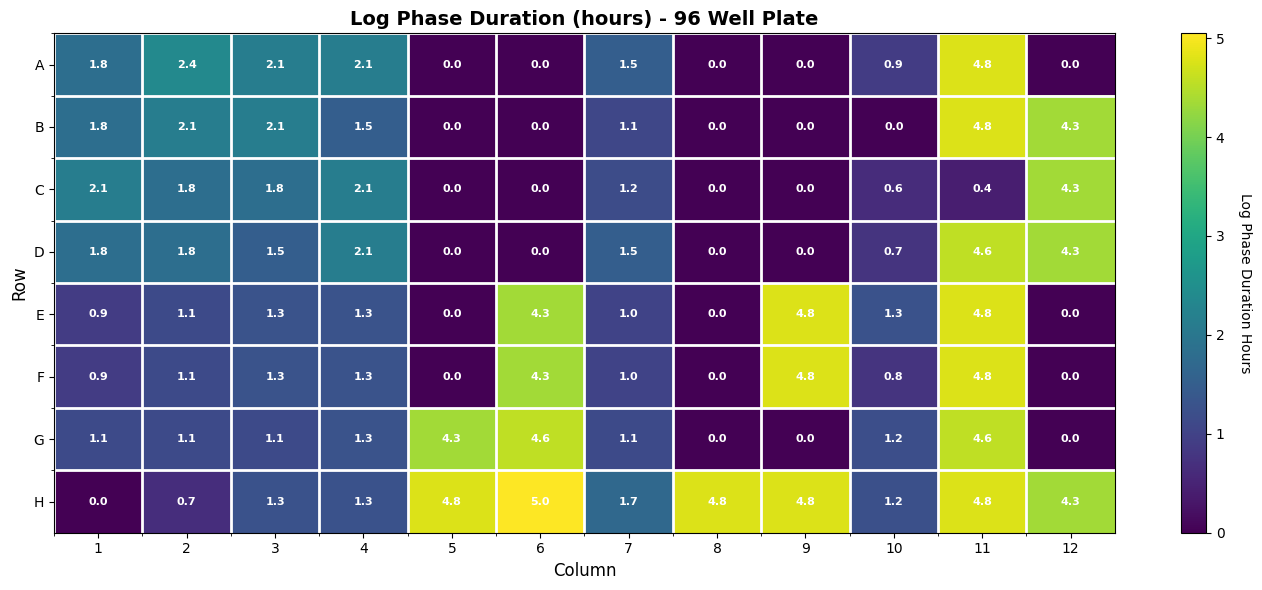

In [12]:
# Create 96-well plate heatmap colored by log phase duration
def plot_plate_heatmap(results_df, value_column='log_phase_duration_hours', title='Log Phase Duration by Well'):
    """
    Plot a 96-well plate layout as a heatmap
    
    Parameters:
    - results_df: DataFrame with 'well' column and value column
    - value_column: Column name to use for coloring
    - title: Title for the plot
    """
    # Initialize 8x12 plate array with NaN
    plate = np.full((8, 12), np.nan)
    
    # Row letters to indices
    row_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}
    results_df.replace('False',0,inplace=True)
    # Fill plate array with values
    for _, row in results_df.iterrows():
        well = row['well']
        row_letter = well[0]
        col_num = int(well[1:]) - 1  # Convert to 0-indexed
        
        if row_letter in row_map and 0 <= col_num < 12:
            plate[row_map[row_letter], col_num] = row[value_column]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create heatmap
    im = ax.imshow(plate, cmap='viridis', aspect='auto', interpolation='nearest')
    
    # Set ticks
    ax.set_xticks(np.arange(12))
    ax.set_yticks(np.arange(8))
    ax.set_xticklabels(np.arange(1, 13))
    ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(value_column.replace('_', ' ').title(), rotation=270, labelpad=20)
    
    # Add grid
    ax.set_xticks(np.arange(12) - 0.5, minor=True)
    ax.set_yticks(np.arange(8) - 0.5, minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=2)
    
    # Add text annotations
    for i in range(8):
        for j in range(12):
            if not np.isnan(plate[i, j]):
                text = ax.text(j, i, f'{plate[i, j]:.1f}',
                             ha="center", va="center", color="white", fontsize=8,
                             fontweight='bold')
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Column', fontsize=12)
    ax.set_ylabel('Row', fontsize=12)
    
    plt.tight_layout()
    return fig, ax

# Plot the heatmap
fig, ax = plot_plate_heatmap(results_df_annotated, 'log_phase_duration_hours', 
                              'Log Phase Duration (hours) - 96 Well Plate')
plt.show()


In [80]:
results_df_annotated

,well,log_phase_duration_hours,max_growth_rate,num_log_periods,column,row,sugar,ratio,YE
0,A2,2.366848,1.221699e+08,1,2,A,High,0.25,False
1,B2,1.816057,1.378173e+08,1,2,B,High,0.25,False
2,C2,1.816057,1.035135e+08,1,2,C,High,0.25,False
3,D2,1.816057,1.275863e+08,1,2,D,High,0.25,False
4,E2,1.733168,2.385799e+08,1,2,E,High,0.25,True
...,...,...,...,...,...,...,...,...,...
91,H6,5.048512,3.214440e+07,1,6,H,High,9.00,False
92,A6,4.781428,2.508559e+07,1,6,A,High,9.00,False
93,C6,0.000000,2.433677e+07,0,6,C,High,9.00,False
94,G6,4.565006,2.171676e+07,1,6,G,High,9.00,True


Text(0, 0.5, 'Log Phase Duration (hours)')

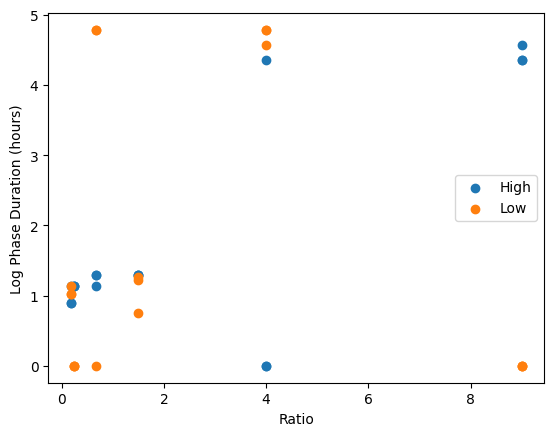

In [114]:
df_temp = results_df_annotated[results_df_annotated['YE']==True]
for sugar in df_temp['sugar'].unique():
    df_temp2 = df_temp[df_temp['sugar']==sugar]
    plt.scatter(df_temp2['ratio'],df_temp2['log_phase_duration_hours'], label=sugar)
plt.legend()
plt.xlabel('Ratio')
plt.ylabel('Log Phase Duration (hours)')

Text(0, 0.5, 'Log Phase Duration (hours)')

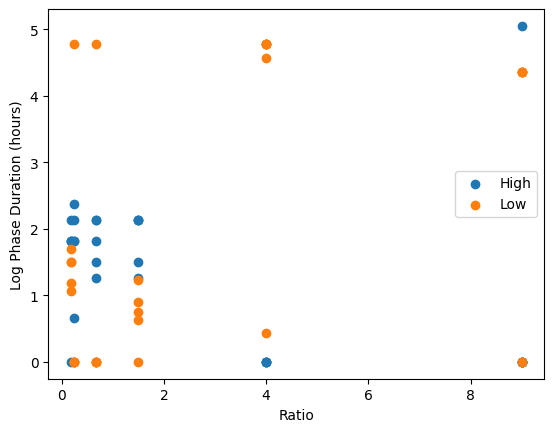

In [115]:
df_temp = results_df_annotated[results_df_annotated['YE']==False]
for sugar in df_temp['sugar'].unique():
    df_temp2 = df_temp[df_temp['sugar']==sugar]
    plt.scatter(df_temp2['ratio'],df_temp2['log_phase_duration_hours'], label=sugar)
plt.legend()
plt.xlabel('Ratio')
plt.ylabel('Log Phase Duration (hours)')

In [44]:
df.groupby('well').max().reset_index().sort_values('cell_concentration_cells_per_ml',ascending=False)

,well,timestamp,culture_id,cell_concentration_cells_per_ml,absorbance_od,absorbance_wavelength_nm,absorbance_bandwidth_nm,absorbance,time_hours
54,E4,2025-10-26 09:36:50.832350+00:00,CLTR1MZMELNZW2K45SMN6YDS3HWAMEM,323300000,0.6665,600.0,9.0,NaN,2.599528
66,F4,2025-10-26 09:36:50.832350+00:00,CLTR1MKXJ6Z33JHXNLHDCEHLTDBLTKE,315600000,0.6876,600.0,9.0,NaN,2.599528
78,G4,2025-10-26 09:36:50.832350+00:00,CLTR16M4ZSL4LN4FVCHXVO6RT4YC7MQ,314900000,0.7096,600.0,9.0,NaN,2.599528
65,F3,2025-10-26 09:36:50.832350+00:00,CLTR14T74BOIAA5LSVJRQRSWAHDWMJE,290500000,NaN,NaN,NaN,0.6826,2.599528
53,E3,2025-10-26 09:36:50.832350+00:00,CLTR144Q2WJCAEPBWBNZTKVETO4WVFM,277300000,NaN,NaN,NaN,0.6712,2.599528
...,...,...,...,...,...,...,...,...,...
3,A12,2025-10-26 15:51:47.937306+00:00,CLTR1HFXVA5C3BR5E5EZ7H6DH6SO4IA,9800000,NaN,NaN,NaN,0.2947,8.848723
47,D9,2025-10-26 15:51:47.937306+00:00,CLTR1XLOFPNKZXNTTNKZID6IQVW62ZE,9200000,NaN,NaN,NaN,0.3114,8.848723
35,C9,2025-10-26 15:51:47.937306+00:00,CLTR1YQQFAUA4QAQ3BY2JTCRZDJY4DI,5300000,NaN,NaN,NaN,0.3021,8.848723
26,C11,2025-10-26 15:51:47.937306+00:00,CLTR1LSP5LSILHRVPD5HMZKLZSOYPEI,4000000,NaN,NaN,NaN,0.2948,8.848723


In [119]:
from bokeh.models import ColumnDataSource, Select
from bokeh.plotting import figure, show
from bokeh.layouts import column, row
from bokeh.io import curdoc

In [121]:
source = ColumnDataSource(results_df_annotated)

p = figure(width=800, height=400, 
           title="Growth Curves by Well", 
           x_axis_label="Time (hours)", 
           y_axis_label="Cell Concentration (cells/mL)")

# Plot all wells
for well in df['well'].unique():
    well_data = results_df_annotated[results_df_annotated['well'] == well]
    p.line('time_hours', 'cell_concentration_cells_per_ml', 
           source=ColumnDataSource(well_data), 
           line_width=2, alpha=0.5, legend_label=well)

p.legend.visible = False

# Dropdowns for filtering
sugar_select = Select(title="Sugar level:", value="All", options=["All"] + sorted(results_df_annotated['sugar'].unique()))
ye_select = Select(title="YE rows:", value="All", options=["All", "True", "False"])

# --- Filter callback ---
def update_plot(attr, old, new):
    sugar_val = sugar_select.value
    ye_val = ye_select.value
    
    filtered = df.copy()
    if sugar_val != "All":
        filtered = filtered[filtered['sugar'] == sugar_val]
    if ye_val != "All":
        filtered = filtered[filtered['YE'] == (ye_val == "True")]
    
    p.renderers = []  # Clear current lines
    for well in filtered['well'].unique():
        well_data = filtered[filtered['well'] == well]
        p.line('time_hours', 'cell_concentration_cells_per_ml', 
               source=ColumnDataSource(well_data), 
               line_width=2, alpha=0.6, legend_label=well)

sugar_select.on_change('value', update_plot)
ye_select.on_change('value', update_plot)

layout = column(row(sugar_select, ye_select), p)
curdoc().add_root(layout)

In [ ]:
# --- Use Python interactivity instead ---
from bokeh.models import CDSView, BooleanFilter
from ipywidgets import interact
# --- Initial source ---
source = ColumnDataSource(results_df_annotated)

# Create the figure
p = figure(width=800, height=400,
           title="Growth Curves by Well",
           x_axis_label="Time (hours)",
           y_axis_label="Cell Concentration (cells/mL)")

# Draw initial plot (all wells)
for well in results_df_annotated['well'].unique():
    subset = results_df_annotated[results_df_annotated['well'] == well]
    p.line('time_hours', 'cell_concentration_cells_per_ml', 
           source=ColumnDataSource(subset), 
           line_width=2, alpha=0.5)

# --- Dropdowns ---
sugar_options = ["All"] + sorted(results_df_annotated['sugar'].unique())
ye_options = ["All", "True", "False"]

sugar_select = Select(title="Sugar level:", value="All", options=sugar_options)
ye_select = Select(title="YE rows:", value="All", options=ye_options)

@interact(
    sugar=sugar_options,
    ye=ye_options
)
def update_plot(sugar="All", ye="All"):
    p.renderers = []  # Clear current lines
    
    mask = pd.Series(True, index=df.index)
    if sugar != "All":
        mask &= results_df_annotated["sugar"] == sugar
    if ye != "All":
        mask &= results_df_annotated["YE"] == (ye == "True")
    
    filtered = df[mask]
    for well in filtered['well'].unique():
        sub = filtered[filtered['well'] == well]
        p.line(sub['time_hours'], sub['cell_concentration_cells_per_ml'],
               line_width=2, alpha=0.6)
    
    show(p)